# Forecasting metrics: case 6

In this notebooks forecast metrics for all models fitted for the simulation case 6 are calculated and saved to a single file.

In [10]:
import os
import sys
import pickle

import tensorflow as tf
import pandas as pd

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Metrics.metrics import get_model_metrics
from DataSimulation.utils import plot_fit
from Transformers.model import Forecaster


## Data

In [11]:
case = "case_6"
case_path = os.path.join(src_path, "Notebooks", "data_generation_and_models_fitting", case)

In [12]:
data = pd.read_csv(os.path.join(case_path, 'data.csv'), header=None)
data.head()

0    1     2     3     4     5     6      7     8      9   ...   90    91  \
0  6.0  3.0   6.0  95.0   7.0  34.0  63.0  354.0   5.0  152.0  ...  6.0  19.0   
1  6.0  3.0   5.0  83.0   3.0  32.0  63.0  352.0   5.0  150.0  ...  2.0  14.0   
2  5.0  3.0   8.0  83.0   4.0  33.0  71.0  343.0  10.0  152.0  ...  0.0  21.0   
3  8.0  3.0  10.0  98.0   9.0  37.0  66.0  339.0   4.0  167.0  ...  2.0  16.0   
4  6.0  5.0   7.0  85.0  12.0  28.0  61.0  324.0   2.0  169.0  ...  0.0  18.0   

     92     93    94    95    96    97    98   99  
0  23.0  217.0  34.0   9.0   6.0   5.0  24.0  7.0  
1  24.0  215.0  32.0   6.0  10.0  10.0  22.0  8.0  
2  24.0  226.0  36.0   8.0   5.0  10.0  24.0  8.0  
3  18.0  225.0  40.0  10.0   9.0  13.0  21.0  7.0  
4  17.0  208.0  39.0  14.0   6.0  10.0  20.0  9.0  

[5 rows x 100 columns]

In [13]:
test_size = 12
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(188, 100)
(12, 100)


In [14]:
metrics = {}
metrics_statistics = {}

## Sarima model

In [15]:
with open(os.path.join(case_path, "sarima.pkl"), "rb") as file:
    sarima_model = pickle.load(file)

In [16]:
sarima_prediction = sarima_model.predict(test_size)

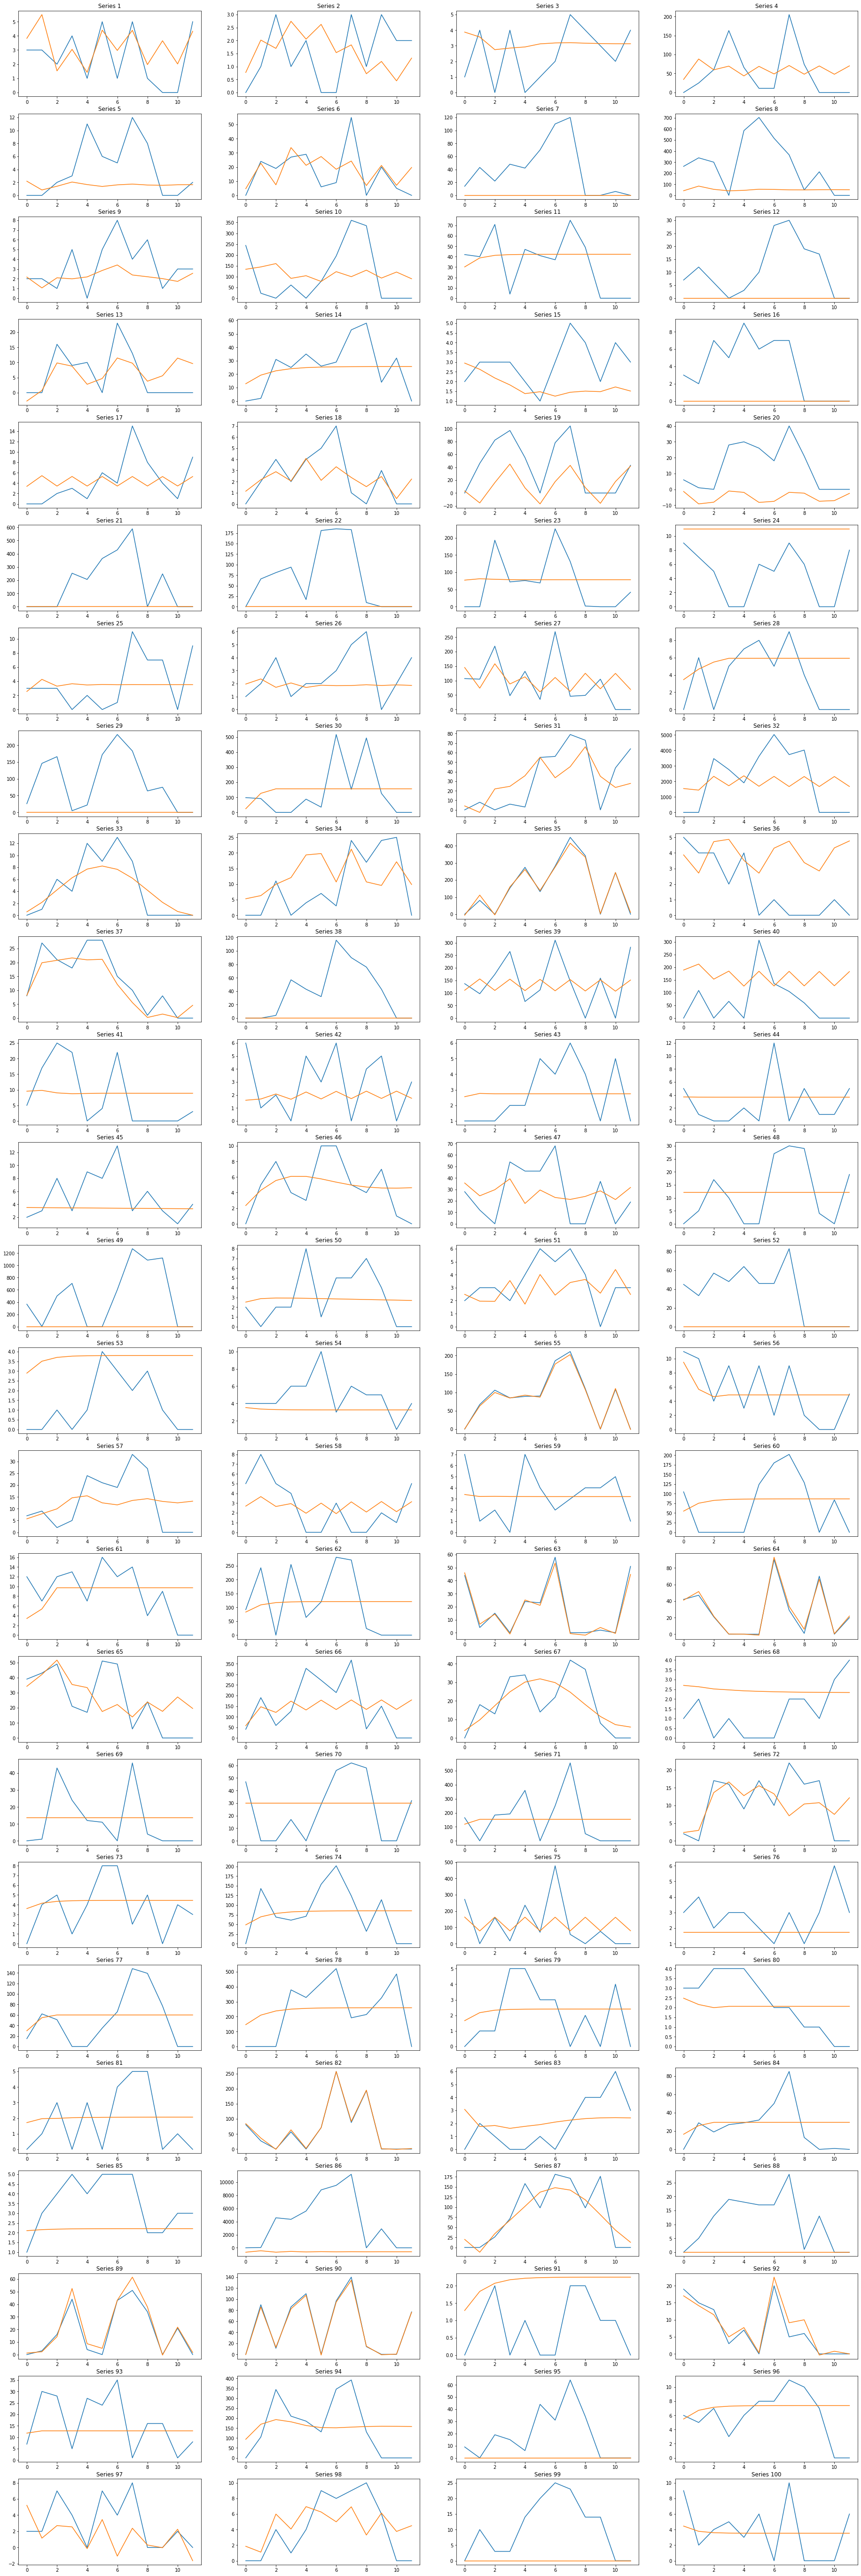

In [17]:
plot_fit(test_data, sarima_prediction, predicted=True, cols=4)

In [18]:
sarima_metrics, sarima_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=sarima_prediction,
    train_data=train_data,
    m=1,
    model_name="sarima",
    case=case
)
metrics.update(sarima_metrics)
metrics_statistics.update(sarima_statistics)

## Poisson Autoregression model

In [19]:
with open(os.path.join(case_path, "poisson_autoregression.pkl"), "rb") as file:
    poisson_ar_model = pickle.load(file)

In [20]:
poisson_ar_prediction = poisson_ar_model.predict(test_size)

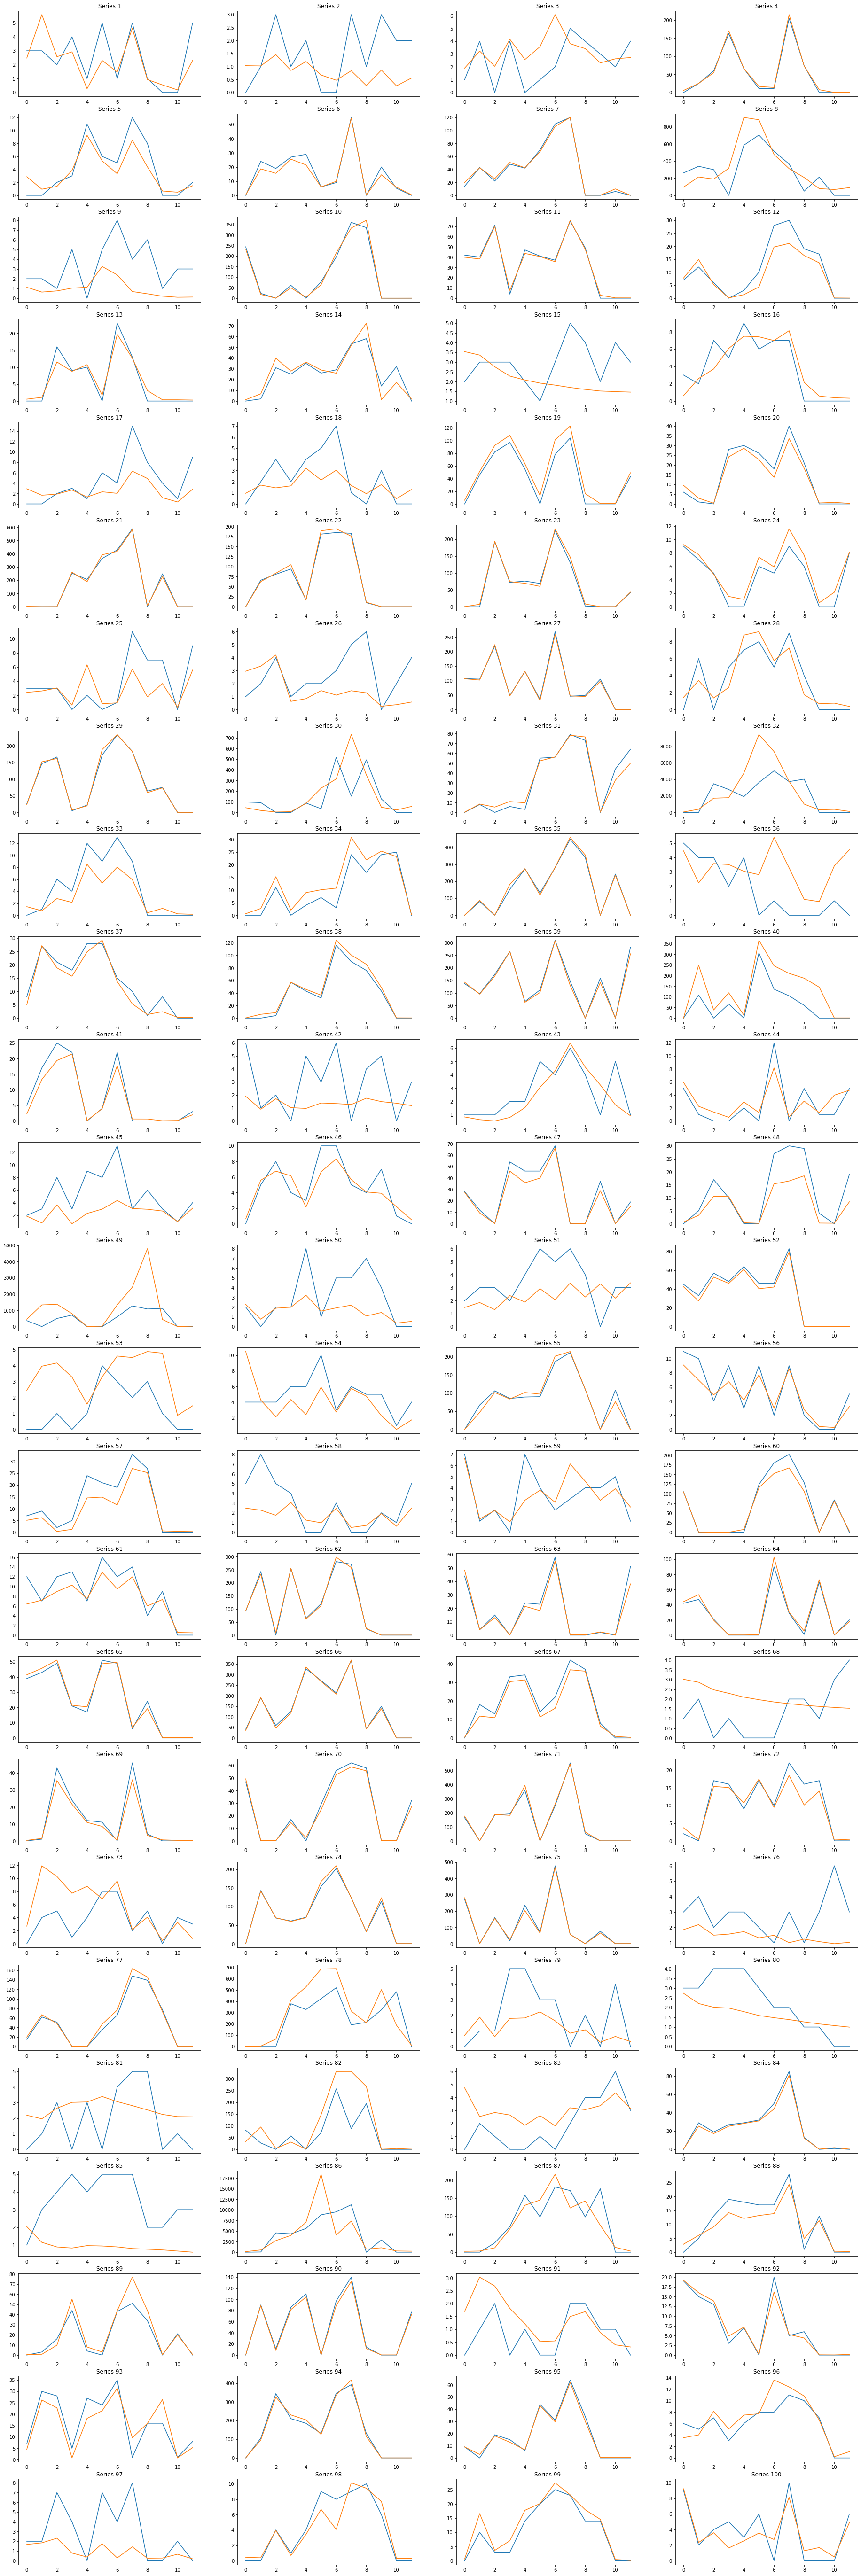

In [21]:
plot_fit(test_data, poisson_ar_prediction, predicted=True, cols=4)

In [22]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=poisson_ar_prediction,
    train_data=train_data,
    m=1,
    model_name="poisson_autorregression",
    case=case
)
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

## Recurrent Neural Network

The model summary in the "rnn_fit.ipynb" allows to know that the best model uses a 12 timesteps input

In [23]:
input_steps=12

In [24]:
with open(os.path.join(case_path, "rnn_scaler.pkl"), "rb") as file:
    rnn_scaler = pickle.load(file)

In [25]:
scaled_data = rnn_scaler.transform(train_data[-input_steps:]).reshape((1,input_steps,-1))

In [26]:
rnn_model = tf.keras.models.load_model(os.path.join(case_path, "rnn.h5"))

In [27]:
rnn_prediction = rnn_model.predict(scaled_data)

1/1 [==============================] - 3s 3s/step


In [28]:
rnn_prediction = rnn_scaler.inverse_transform(rnn_prediction[0])

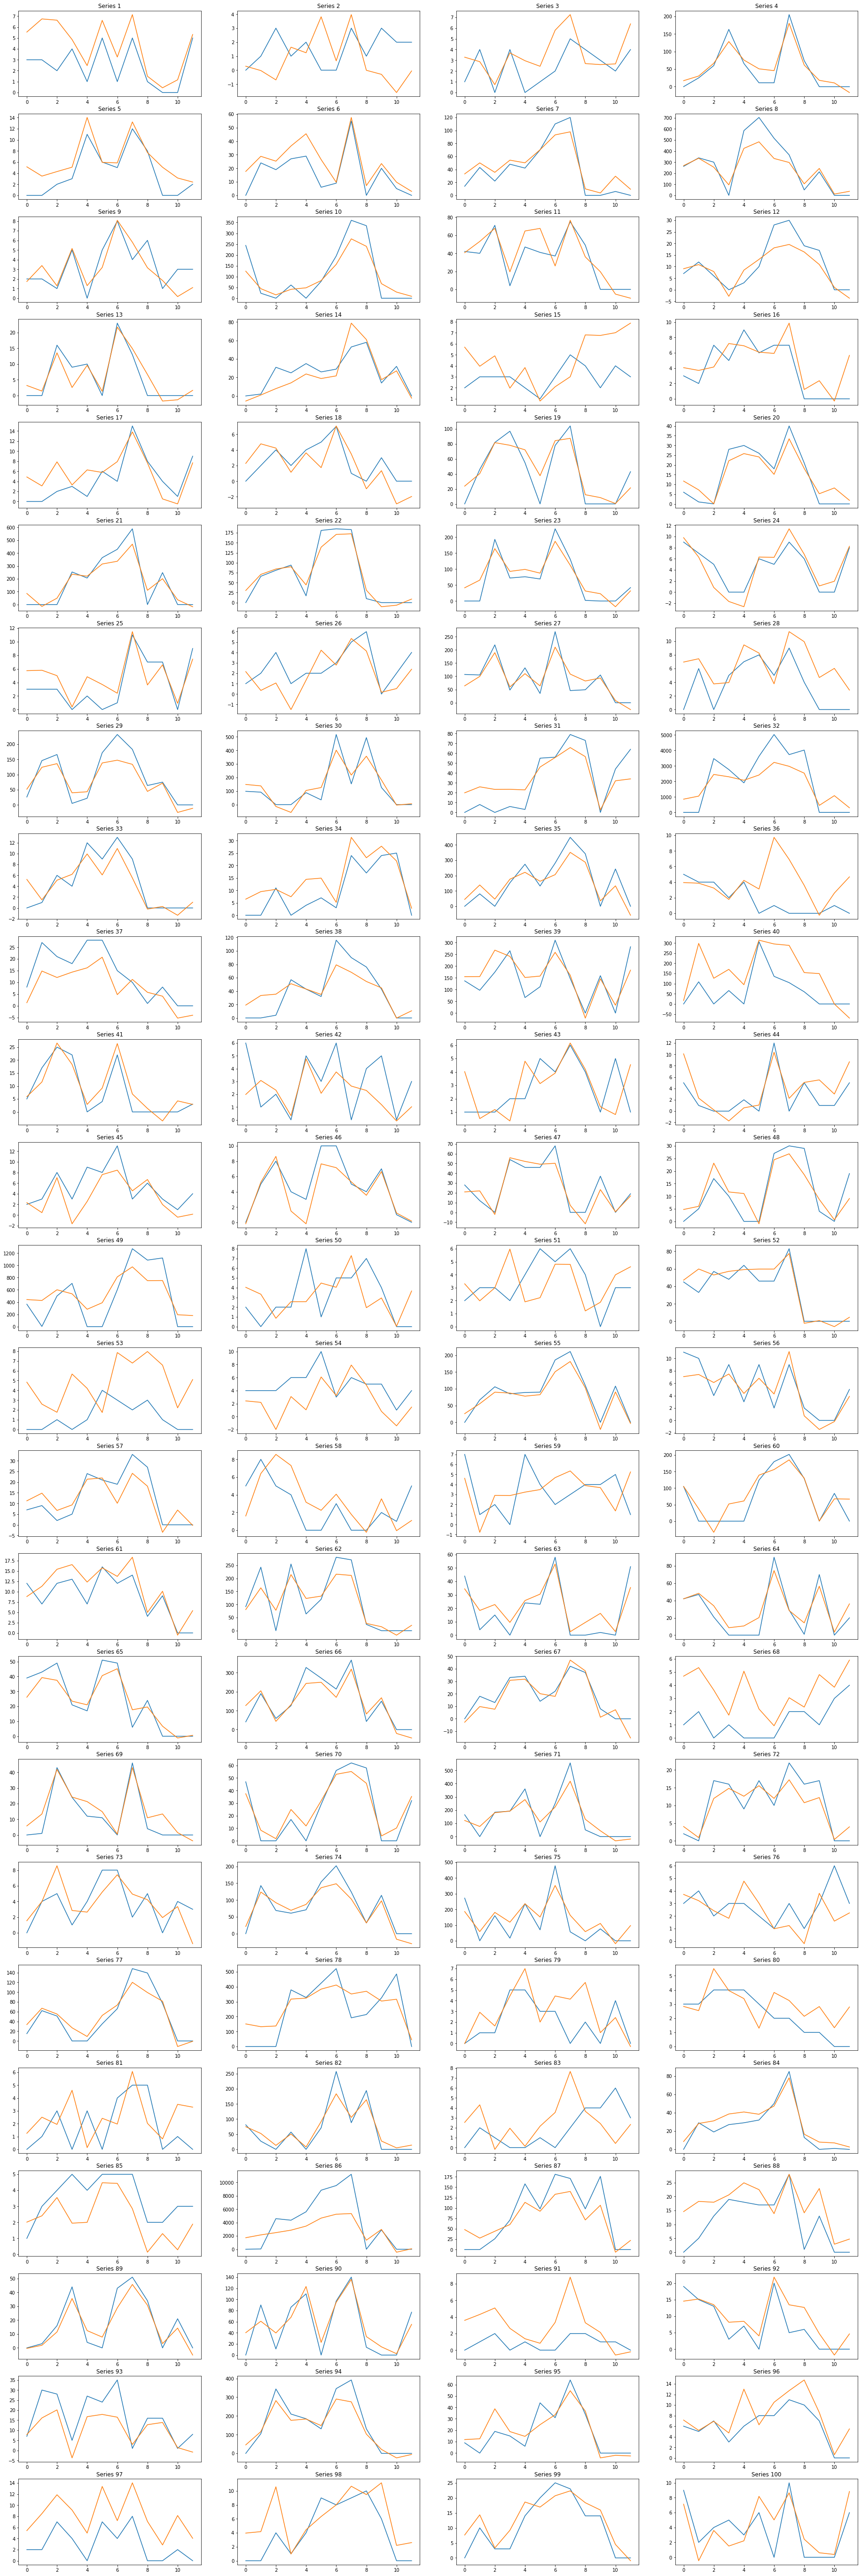

In [29]:
plot_fit(test_data, rnn_prediction, predicted=True, cols=4)

In [30]:
rnn_metrics, rnn_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=rnn_prediction,
    train_data=train_data,
    m=1,
    model_name="recurrent_neural_network",
    case=case
)
metrics.update(rnn_metrics)
metrics_statistics.update(rnn_statistics)

## Transformer model

In [31]:
with open(os.path.join(case_path, "transformer_scaler.pkl"), "rb") as file:
    transformer_scaler = pickle.load(file)

In [32]:
transformer_model = tf.keras.models.load_model(os.path.join(case_path, "transformer.tf"))

In [33]:
forecaster = Forecaster(transformer_scaler, transformer_model)

In [34]:
inputs = train_data[-12:]

In [35]:
transformer_prediction = forecaster(inputs=inputs, steps=12)

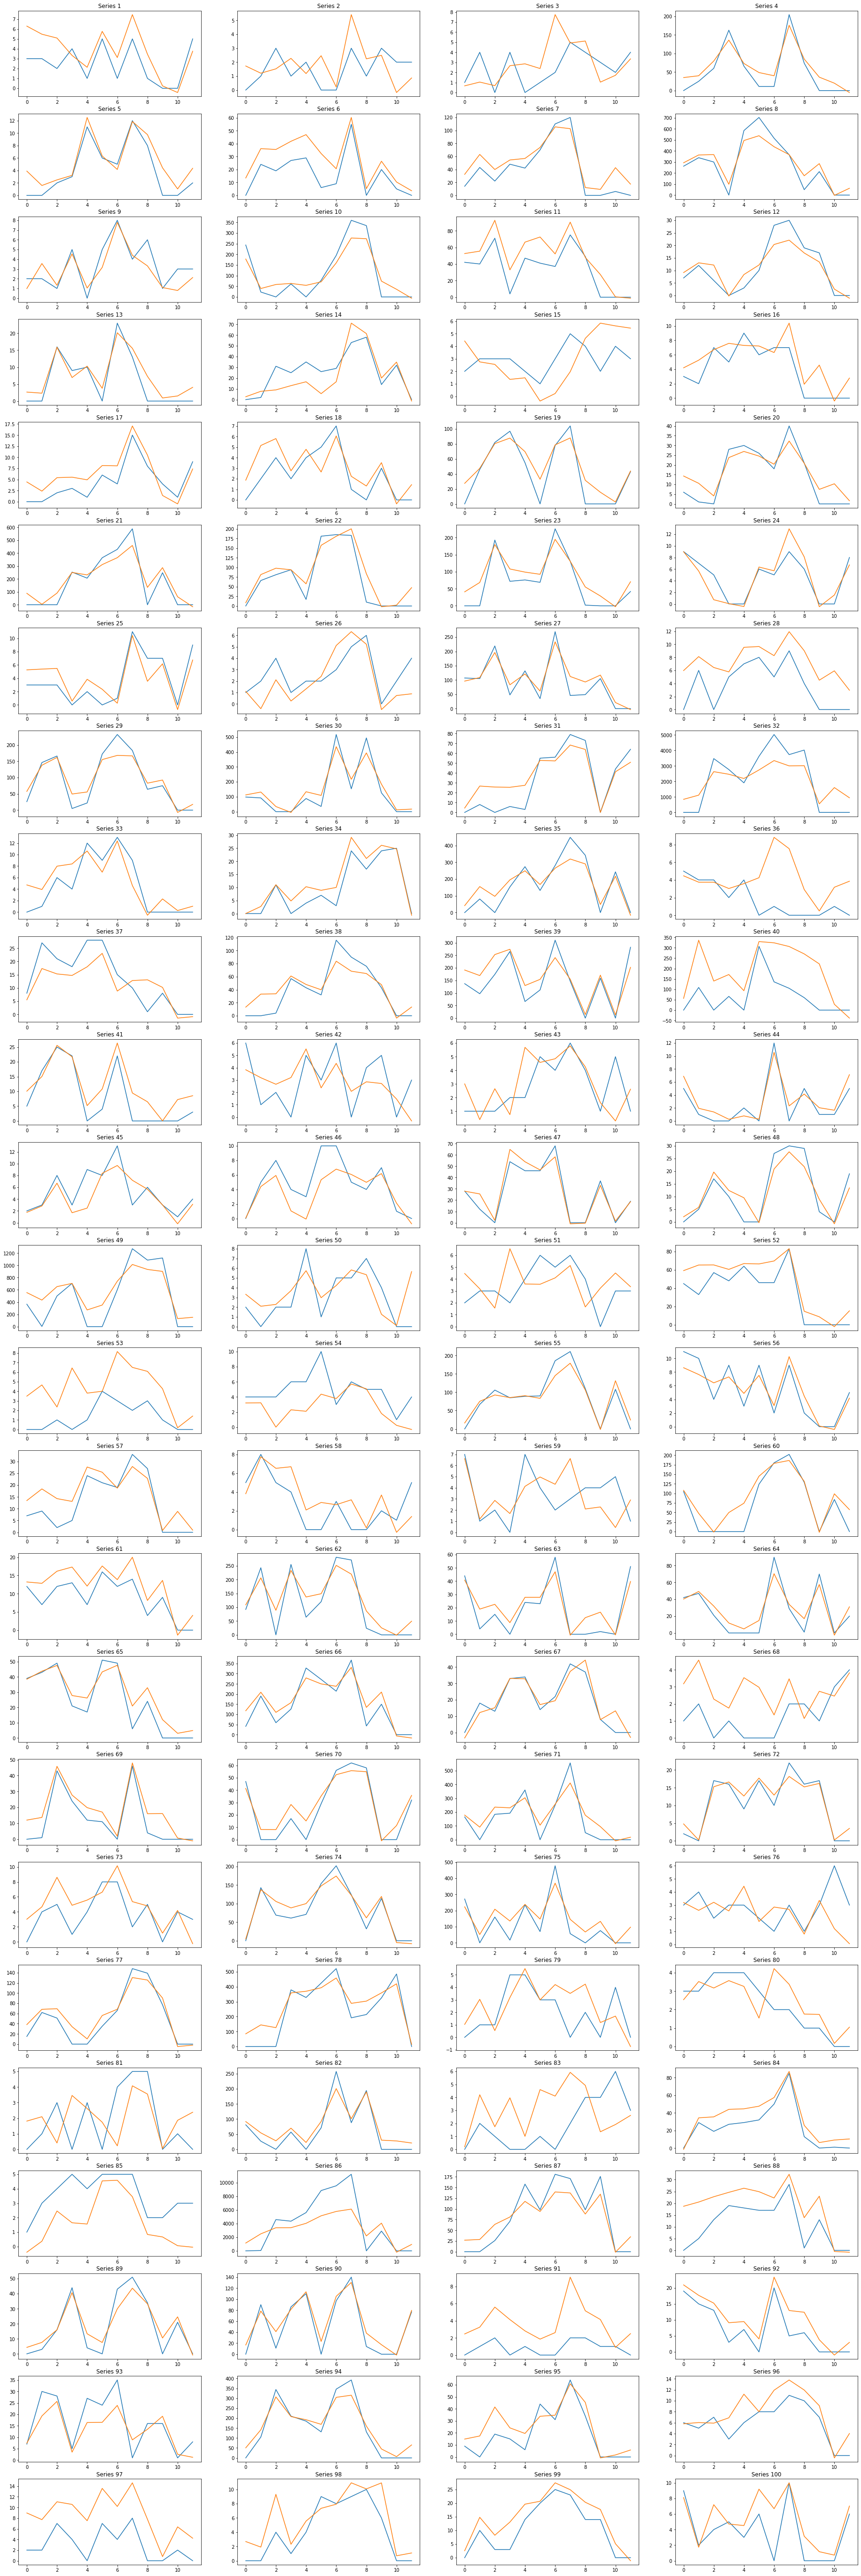

In [36]:
plot_fit(test_data, transformer_prediction, predicted=True, cols=4)

In [37]:
transformer_metrics, transformer_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=transformer_prediction,
    train_data=train_data,
    m=1,
    model_name="transformer",
    case=case
)
metrics.update(transformer_metrics)
metrics_statistics.update(transformer_statistics)

## Metrics results

In [38]:
pd.DataFrame(metrics_statistics)

sarima           poisson_autorregression            \
                  sMAPE      MASE                   sMAPE      MASE   
case_6 mean  101.177502  1.313033               82.772233  0.596172   
       sd     32.898398  0.814966               23.730734  0.649605   
       min    45.583668  0.049365               36.826579  0.059711   
       max   200.000000  5.274056              132.777676  4.510954   

            recurrent_neural_network           transformer            
                               sMAPE      MASE       sMAPE      MASE  
case_6 mean                89.455783  0.826255   87.846508  0.791624  
       sd                  20.516289  0.359105   18.936948  0.353987  
       min                 54.223840  0.362285   46.012753  0.296645  
       max                160.231900  2.512390  142.077897  2.368637

In [39]:
with open("metrics.pkl", "wb") as outfile:
    pickle.dump(metrics, outfile)

with open("statistics.pkl", "wb") as outfile:
    pickle.dump(metrics_statistics, outfile)